In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import metrics

# Base

In [2]:
# Importando a base
train = pd.read_csv('train_treated.csv', index_col=0)

In [3]:
train.sample(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
885,0,3,0,25.000000,0,0,7.0500,0,0,1
541,1,1,1,36.000000,0,2,71.0000,0,0,1
79,1,2,0,0.830000,0,2,29.0000,0,0,1
109,0,3,0,38.000000,0,0,7.8958,0,0,1
411,0,3,0,29.699118,0,0,7.8958,0,0,1


## Dividindo entre treino e teste

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train.drop(columns=['Survived']), train['Survived'], test_size=0.25, random_state=0)

# Criando dicionario de scores

In [5]:
# Importando os melhores modelos pós gridsearch
import pickle
filename = 'gridsearch_scores'
infile = open(filename,'rb')
metrics_dict = pickle.load(infile)
infile.close()

In [6]:
metrics_dict.keys()

dict_keys(['Logistic GS', 'SVM GS', 'Decision GS', 'Neural GS'])

In [7]:
pd.DataFrame(metrics_dict.values())

,label,accuracy,recall,precision,F1,predict,classifier
0,Logistic GS,0.802691,0.777778,0.666667,0.717949,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","LogisticRegression(C=0.045227288910538066, cla..."
1,SVM GS,0.784753,0.714286,0.714286,0.714286,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","SVC(C=492.1132712266245, break_ties=False, cac..."
2,Decision GS,0.820628,0.782051,0.726190,0.753086,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
3,Neural GS,0.820628,0.782051,0.726190,0.753086,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","MLPClassifier(activation='relu', alpha=0.01, b..."


In [8]:
def update_dict(name, predict, classifier, dictionary):
    dictionary[name] = {
        'label': name, 
        'accuracy': metrics.accuracy_score(predict, y_test), 
        'recall': metrics.recall_score(predict, y_test), 
        'precision': metrics.precision_score(predict, y_test), 
        'F1': metrics.f1_score(predict, y_test),
        'predict': predict,
        'classifier': classifier
    }
    return dictionary
    
def update_score_dict(name, predict, classifier):
    update_dict(name, predict, classifier, metrics_dict)

# Bagging e boosting

In [9]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

In [10]:
def test_num_estimators(classifier, estimator, n_est):
    num_estimators = n_est if n_est else [20, 25, 30, 40, 60, 80, 90, 100]
    results_dict = {elem: {} for elem in num_estimators}


    for i in num_estimators:
        classif = classifier(base_estimator=estimator, n_estimators=i, random_state=0)
        classif.fit(x_train, y_train)
        classif_predict = classif.predict(x_test)
        update_dict(i, classif_predict, classif, results_dict)
        
    return results_dict

## Boosting

In [11]:
def test_num_estimators_for_boosting(estimator, n_est=None):
    return test_num_estimators(AdaBoostClassifier, estimator, n_est)

## Bagging

In [12]:
def test_num_estimators_for_bagging(estimator, n_est=None):
    return test_num_estimators(BaggingClassifier, estimator, n_est)

# LogisticRegression

In [13]:
# Importando
from sklearn.linear_model import LogisticRegression
# Instanciando
logisticR = metrics_dict['Logistic GS']['classifier']

## Boosting

In [14]:
n_est_LR = [100, 200, 300, 350, 400, 410, 415, 420, 425, 450, 470, 500]
results_dict_LR = test_num_estimators_for_boosting(logisticR, n_est_LR)

In [15]:
# Ordered by F1
newlist_LR = sorted(list(results_dict_LR.values()), key=lambda k: k['F1']) 
pd.DataFrame(newlist_LR)

,label,accuracy,recall,precision,F1,predict,classifier
0,100,0.744395,0.909091,0.357143,0.512821,"[0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...","(LogisticRegression(C=0.045227288910538066, cl..."
1,200,0.780269,0.857143,0.500000,0.631579,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...","(LogisticRegression(C=0.045227288910538066, cl..."
2,300,0.793722,0.796875,0.607143,0.689189,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","(LogisticRegression(C=0.045227288910538066, cl..."
3,450,0.789238,0.746667,0.666667,0.704403,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(LogisticRegression(C=0.045227288910538066, cl..."
4,350,0.798206,0.782609,0.642857,0.705882,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(LogisticRegression(C=0.045227288910538066, cl..."
5,470,0.789238,0.740260,0.678571,0.708075,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(LogisticRegression(C=0.045227288910538066, cl..."
6,500,0.789238,0.740260,0.678571,0.708075,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(LogisticRegression(C=0.045227288910538066, cl..."
7,400,0.802691,0.777778,0.666667,0.717949,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(LogisticRegression(C=0.045227288910538066, cl..."
8,410,0.802691,0.777778,0.666667,0.717949,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(LogisticRegression(C=0.045227288910538066, cl..."
9,415,0.802691,0.777778,0.666667,0.717949,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(LogisticRegression(C=0.045227288910538066, cl..."


In [16]:
adaboost_logistic_best = results_dict_LR[400]

In [17]:
update_score_dict('Logistic GS Ada', adaboost_logistic_best['predict'], adaboost_logistic_best['classifier'])
pd.DataFrame(metrics_dict.values())

,label,accuracy,recall,precision,F1,predict,classifier
0,Logistic GS,0.802691,0.777778,0.666667,0.717949,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","LogisticRegression(C=0.045227288910538066, cla..."
1,SVM GS,0.784753,0.714286,0.714286,0.714286,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","SVC(C=492.1132712266245, break_ties=False, cac..."
2,Decision GS,0.820628,0.782051,0.726190,0.753086,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
3,Neural GS,0.820628,0.782051,0.726190,0.753086,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","MLPClassifier(activation='relu', alpha=0.01, b..."
4,Logistic GS Ada,0.802691,0.777778,0.666667,0.717949,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(LogisticRegression(C=0.045227288910538066, cl..."


# Máquina de Vetor Suporte

In [18]:
# Importando
from sklearn.svm import SVC
# Instanciando
supportV = metrics_dict['SVM GS']['classifier']

## Bagging

In [19]:
results_dict_SVM = test_num_estimators_for_bagging(supportV)

In [20]:
# Ordered by F1
newlist_SVM = sorted(list(results_dict_SVM.values()), key=lambda k: k['F1']) 
pd.DataFrame(newlist_SVM)

,label,accuracy,recall,precision,F1,predict,classifier
0,40,0.784753,0.725000,0.690476,0.707317,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","(SVC(C=492.1132712266245, break_ties=False, ca..."
1,60,0.784753,0.725000,0.690476,0.707317,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","(SVC(C=492.1132712266245, break_ties=False, ca..."
2,80,0.784753,0.725000,0.690476,0.707317,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","(SVC(C=492.1132712266245, break_ties=False, ca..."
3,90,0.784753,0.725000,0.690476,0.707317,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","(SVC(C=492.1132712266245, break_ties=False, ca..."
4,100,0.784753,0.725000,0.690476,0.707317,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","(SVC(C=492.1132712266245, break_ties=False, ca..."
5,20,0.789238,0.728395,0.702381,0.715152,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","(SVC(C=492.1132712266245, break_ties=False, ca..."
6,25,0.789238,0.728395,0.702381,0.715152,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","(SVC(C=492.1132712266245, break_ties=False, ca..."
7,30,0.789238,0.728395,0.702381,0.715152,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","(SVC(C=492.1132712266245, break_ties=False, ca..."


In [21]:
n_est_SVM = [300, 400, 500, 600]
results_dict_SVM_high = test_num_estimators_for_bagging(supportV, n_est_SVM)

In [22]:
# Ordered by F1
newlist_SVM_high = sorted(list(results_dict_SVM_high.values()), key=lambda k: k['F1']) 
pd.DataFrame(newlist_SVM_high)

,label,accuracy,recall,precision,F1,predict,classifier
0,400,0.780269,0.721519,0.678571,0.699387,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","(SVC(C=492.1132712266245, break_ties=False, ca..."
1,500,0.780269,0.721519,0.678571,0.699387,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","(SVC(C=492.1132712266245, break_ties=False, ca..."
2,300,0.784753,0.725000,0.690476,0.707317,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","(SVC(C=492.1132712266245, break_ties=False, ca..."
3,600,0.784753,0.725000,0.690476,0.707317,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","(SVC(C=492.1132712266245, break_ties=False, ca..."


In [23]:
bagging_svm_best = results_dict_SVM[20]

In [24]:
update_score_dict('SVM GS Bagging', bagging_svm_best['predict'], bagging_svm_best['classifier'])
pd.DataFrame(metrics_dict.values())

,label,accuracy,recall,precision,F1,predict,classifier
0,Logistic GS,0.802691,0.777778,0.666667,0.717949,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","LogisticRegression(C=0.045227288910538066, cla..."
1,SVM GS,0.784753,0.714286,0.714286,0.714286,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","SVC(C=492.1132712266245, break_ties=False, cac..."
2,Decision GS,0.820628,0.782051,0.726190,0.753086,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
3,Neural GS,0.820628,0.782051,0.726190,0.753086,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","MLPClassifier(activation='relu', alpha=0.01, b..."
4,Logistic GS Ada,0.802691,0.777778,0.666667,0.717949,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(LogisticRegression(C=0.045227288910538066, cl..."
5,SVM GS Bagging,0.789238,0.728395,0.702381,0.715152,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","(SVC(C=492.1132712266245, break_ties=False, ca..."


# Decision tree

In [25]:
# Importando
from sklearn.tree import DecisionTreeClassifier
# Instanciando
decisionT = metrics_dict['Decision GS']['classifier']

## Boosting

In [26]:
n_est_DT = [20, 25, 30, 35, 37, 39, 40, 45, 50, 53, 55, 57, 60, 80, 90]
results_dict_DT = test_num_estimators_for_boosting(decisionT, n_est_DT)

In [27]:
# Ordered by F1
newlist_DT = sorted(list(results_dict_DT.values()), key=lambda k: k['F1']) 
pd.DataFrame(newlist_DT)

,label,accuracy,recall,precision,F1,predict,classifier
0,30,0.771300,0.708861,0.666667,0.687117,"[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
1,90,0.766816,0.690476,0.690476,0.690476,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
2,57,0.771300,0.703704,0.678571,0.690909,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
3,60,0.771300,0.703704,0.678571,0.690909,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
4,80,0.771300,0.698795,0.690476,0.694611,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
5,55,0.775785,0.712500,0.678571,0.695122,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
6,25,0.771300,0.694118,0.702381,0.698225,"[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
7,53,0.771300,0.694118,0.702381,0.698225,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
8,20,0.775785,0.707317,0.690476,0.698795,"[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
9,45,0.775785,0.702381,0.702381,0.702381,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."


In [28]:
n_est_DT_high = [200, 300, 500, 600, 680, 700, 800, 815, 820, 825, 850, 900, 1000]
results_dict_DT_high = test_num_estimators_for_boosting(decisionT, n_est_DT_high)

In [29]:
# Ordered by F1
newlist_DT_high = sorted(list(results_dict_DT_high.values()), key=lambda k: k['F1']) 
pd.DataFrame(newlist_DT_high)

,label,accuracy,recall,precision,F1,predict,classifier
0,300,0.771300,0.703704,0.678571,0.690909,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
1,200,0.775785,0.717949,0.666667,0.691358,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
2,800,0.789238,0.734177,0.690476,0.711656,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
3,900,0.789238,0.734177,0.690476,0.711656,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
4,850,0.789238,0.728395,0.702381,0.715152,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
5,1000,0.789238,0.722892,0.714286,0.718563,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
6,815,0.793722,0.737500,0.702381,0.719512,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
7,500,0.789238,0.717647,0.726190,0.721893,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
8,680,0.793722,0.731707,0.714286,0.722892,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
9,600,0.793722,0.726190,0.726190,0.726190,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."


In [30]:
adaboost_decisionT_best = results_dict_DT_high[820]

In [31]:
update_score_dict('Decision GS Ada', adaboost_decisionT_best['predict'], adaboost_decisionT_best['classifier'])
pd.DataFrame(metrics_dict.values())

,label,accuracy,recall,precision,F1,predict,classifier
0,Logistic GS,0.802691,0.777778,0.666667,0.717949,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","LogisticRegression(C=0.045227288910538066, cla..."
1,SVM GS,0.784753,0.714286,0.714286,0.714286,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","SVC(C=492.1132712266245, break_ties=False, cac..."
2,Decision GS,0.820628,0.782051,0.726190,0.753086,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
3,Neural GS,0.820628,0.782051,0.726190,0.753086,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","MLPClassifier(activation='relu', alpha=0.01, b..."
4,Logistic GS Ada,0.802691,0.777778,0.666667,0.717949,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(LogisticRegression(C=0.045227288910538066, cl..."
5,SVM GS Bagging,0.789238,0.728395,0.702381,0.715152,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","(SVC(C=492.1132712266245, break_ties=False, ca..."
6,Decision GS Ada,0.802691,0.743902,0.726190,0.734940,"[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."


# Redes Neurais

In [32]:
# Importando
from sklearn.neural_network import MLPClassifier
# Instanciando
neuralN =  metrics_dict['Neural GS']['classifier']

## Bagging

In [33]:
n_est_NN = [10, 20, 23, 25, 30, 60, 65, 70, 80, 85, 100]
results_dict_NN = test_num_estimators_for_bagging(neuralN, n_est_NN)

In [34]:
# Ordered by F1
newlist_NN = sorted(list(results_dict_NN.values()), key=lambda k: k['F1']) 
pd.DataFrame(newlist_NN)

,label,accuracy,recall,precision,F1,predict,classifier
0,20,0.802691,0.743902,0.726190,0.734940,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(MLPClassifier(activation='relu', alpha=0.01, ..."
1,30,0.802691,0.743902,0.726190,0.734940,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(MLPClassifier(activation='relu', alpha=0.01, ..."
2,60,0.802691,0.743902,0.726190,0.734940,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(MLPClassifier(activation='relu', alpha=0.01, ..."
3,65,0.802691,0.743902,0.726190,0.734940,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(MLPClassifier(activation='relu', alpha=0.01, ..."
4,70,0.802691,0.743902,0.726190,0.734940,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(MLPClassifier(activation='relu', alpha=0.01, ..."
5,80,0.802691,0.743902,0.726190,0.734940,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(MLPClassifier(activation='relu', alpha=0.01, ..."
6,85,0.802691,0.743902,0.726190,0.734940,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(MLPClassifier(activation='relu', alpha=0.01, ..."
7,100,0.802691,0.743902,0.726190,0.734940,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(MLPClassifier(activation='relu', alpha=0.01, ..."
8,23,0.811659,0.756098,0.738095,0.746988,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(MLPClassifier(activation='relu', alpha=0.01, ..."
9,25,0.811659,0.756098,0.738095,0.746988,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(MLPClassifier(activation='relu', alpha=0.01, ..."


In [35]:
n_est_NN_low = [1, 5, 7, 8, 9, 10, 13, 15]
results_dict_NN_low = test_num_estimators_for_bagging(neuralN, n_est_NN_low)

In [36]:
# Ordered by F1
newlist_NN_low = sorted(list(results_dict_NN_low.values()), key=lambda k: k['F1']) 
pd.DataFrame(newlist_NN_low)

,label,accuracy,recall,precision,F1,predict,classifier
0,7,0.802691,0.743902,0.726190,0.734940,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(MLPClassifier(activation='relu', alpha=0.01, ..."
1,8,0.802691,0.743902,0.726190,0.734940,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(MLPClassifier(activation='relu', alpha=0.01, ..."
2,1,0.793722,0.711111,0.761905,0.735632,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","(MLPClassifier(activation='relu', alpha=0.01, ..."
3,9,0.807175,0.753086,0.726190,0.739394,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(MLPClassifier(activation='relu', alpha=0.01, ..."
4,5,0.811659,0.762500,0.726190,0.743902,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(MLPClassifier(activation='relu', alpha=0.01, ..."
5,15,0.811659,0.762500,0.726190,0.743902,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(MLPClassifier(activation='relu', alpha=0.01, ..."
6,13,0.811659,0.756098,0.738095,0.746988,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(MLPClassifier(activation='relu', alpha=0.01, ..."
7,10,0.816143,0.765432,0.738095,0.751515,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(MLPClassifier(activation='relu', alpha=0.01, ..."


In [37]:
bagging_neuralN_best = results_dict_NN[10]

In [38]:
update_score_dict('Neural GS Bagging', bagging_neuralN_best['predict'], bagging_neuralN_best['classifier'])

# Scores

In [39]:
pd.DataFrame(metrics_dict.values())

,label,accuracy,recall,precision,F1,predict,classifier
0,Logistic GS,0.802691,0.777778,0.666667,0.717949,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","LogisticRegression(C=0.045227288910538066, cla..."
1,SVM GS,0.784753,0.714286,0.714286,0.714286,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","SVC(C=492.1132712266245, break_ties=False, cac..."
2,Decision GS,0.820628,0.782051,0.726190,0.753086,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
3,Neural GS,0.820628,0.782051,0.726190,0.753086,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","MLPClassifier(activation='relu', alpha=0.01, b..."
4,Logistic GS Ada,0.802691,0.777778,0.666667,0.717949,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(LogisticRegression(C=0.045227288910538066, cl..."
5,SVM GS Bagging,0.789238,0.728395,0.702381,0.715152,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","(SVC(C=492.1132712266245, break_ties=False, ca..."
6,Decision GS Ada,0.802691,0.743902,0.726190,0.734940,"[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
7,Neural GS Bagging,0.816143,0.765432,0.738095,0.751515,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(MLPClassifier(activation='relu', alpha=0.01, ..."


In [40]:
# Ordered by F1
newlist = sorted(list(metrics_dict.values()), key=lambda k: k['F1']) 
f1_ordered = pd.DataFrame(newlist)
f1_ordered

,label,accuracy,recall,precision,F1,predict,classifier
0,SVM GS,0.784753,0.714286,0.714286,0.714286,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","SVC(C=492.1132712266245, break_ties=False, cac..."
1,SVM GS Bagging,0.789238,0.728395,0.702381,0.715152,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","(SVC(C=492.1132712266245, break_ties=False, ca..."
2,Logistic GS,0.802691,0.777778,0.666667,0.717949,"[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","LogisticRegression(C=0.045227288910538066, cla..."
3,Logistic GS Ada,0.802691,0.777778,0.666667,0.717949,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(LogisticRegression(C=0.045227288910538066, cl..."
4,Decision GS Ada,0.802691,0.743902,0.726190,0.734940,"[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
5,Neural GS Bagging,0.816143,0.765432,0.738095,0.751515,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","(MLPClassifier(activation='relu', alpha=0.01, ..."
6,Decision GS,0.820628,0.782051,0.726190,0.753086,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
7,Neural GS,0.820628,0.782051,0.726190,0.753086,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, ...","MLPClassifier(activation='relu', alpha=0.01, b..."


In [41]:
for keys in [['Logistic GS', 'Logistic GS Ada'], ['SVM GS', 'SVM GS Bagging'], ['Decision GS', 'Decision GS Ada'], ['Neural GS', 'Neural GS Bagging']]:
    selected_methods_dict = {x:metrics_dict[x] for x in keys}
    
    print(pd.DataFrame(selected_methods_dict).drop(['label', 'predict', 'classifier', 'recall', 'precision']))

         Logistic GS Logistic GS Ada
accuracy    0.802691        0.802691
F1          0.717949        0.717949
            SVM GS SVM GS Bagging
accuracy  0.784753       0.789238
F1        0.714286       0.715152
         Decision GS Decision GS Ada
accuracy    0.820628        0.802691
F1          0.753086         0.73494
         Neural GS Neural GS Bagging
accuracy  0.820628          0.816143
F1        0.753086          0.751515


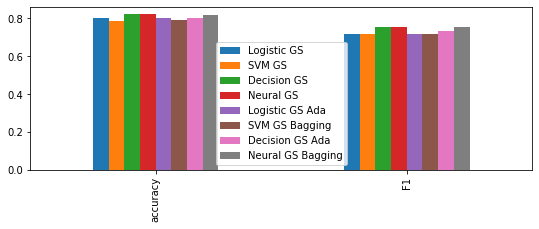

In [42]:
pd.DataFrame(metrics_dict).drop(['label', 'recall', 'precision', 'predict', 'classifier']).plot(kind='bar', figsize=(9,3))

# Salvando resultados

In [43]:
keys = ['Logistic GS', 'SVM GS Bagging', 'Decision GS', 'Neural GS']
selected_methods_dict = {x:metrics_dict[x] for x in keys}

In [44]:
# salvando 
import pickle
filename = 'amostragem_scores'
outfile = open(filename, 'wb')
pickle.dump(selected_methods_dict, outfile)
outfile.close()